# Clasificador Binario

## Librerías

In [114]:
!pip install fastai -Uq
!pip install timm

#Reiniciamos el entorno de ejecución automáticamente
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


{'restart': True, 'status': 'ok'}

In [ ]:
from fastai.vision.all import *

## Dataset

En este caso estamos usando el dataset que ha sido preprocesados mediante el método de recorte

In [ ]:
!wget https://www.dropbox.com/s/o1eaoae59qgdo4i/Training_Set_Pre.zip?dl=0 --no-verbose -O train.zip
!wget https://www.dropbox.com/s/5od5cac9xhxlcwu/Test_Set_Pre.zip?dl=0 --no-verbose -O test.zip
!wget https://www.dropbox.com/s/gjz445xm4oddfus/Evaluation_Set_Pre.zip?dl=0 --no-verbose -O val.zip


2022-06-14 16:48:08 URL:https://ucfddb3782cfc7edfbb002e06115.dl.dropboxusercontent.com/cd/0/inline2/BnPZCpJwG3Ccsm0TYYIFZeSvbKCOL5Re2qzrvCophXcn_nBx7DoHe_RSOooV8YCS8AWuAVzE6D5u_NjAQlzLAF3b4HbRbMm9VSU4NDoRrMJWMUM726CnySnIW4rqagMxWUai2L4EsCoIIsjftM6kp4C6Lt1YaYJ-eIpv6wtLXJAVoxqC2ejjM7crpcXogCU41_ljazEMVv0T4WXnqt2y-JfLZzjlcsVUFHYNkAlkmwl304tsMTjh5J0fKnzZm5MnWu_i0S_dsr3_rVF7oVxlCck-mFpRxJB6ZIQ4PtsrpxvmH12B515tchGZCGJsJXPDOCErvgYJp6EwSTEakYwISTw8c4uTysLWTkMHSDY2yMjQnT7duMh8CMLorAQZSeH_q0wf5XO3jD-vmLghi1tw_0elBu548qYEb5G_6GEgeOKCcw/file [138777773/138777773] -> "train.zip" [1]
2022-06-14 16:48:11 URL:https://uc749addf217738dbe6fb5eb8d13.dl.dropboxusercontent.com/cd/0/inline2/BnOIj6VgoNuj73aIw1RvDB1t2zGB-7IAPn6kqM4nziQGF7TolbzhYMV370LCqdJmJM_AoNm8Aw1A2uoAXkwiioi_2JFA-mz9hiGGaOntpRUg1u-0omyUOoOOU3pYoKA1Xy0Qi6ZEMJ9mNe0fAhJ3nsMvmCLqduCWSNt2LejuL0TqR6AHVMbtmtw7zhdH1Ys8cAlCBag993n4pe_2ITVdV_5qkQJG6aD1Vp80ymADGSpClAbAypxKniKG0zjKerlQIfRDkQblabhtTxQOyGPQUzLqQNMlhVEzXnYFYYKNVQgNaxZHE8tYHekdt8dluftLLbI

In [ ]:
# !rm -rvf Training_Set_Pre
!unzip -qq train.zip #-qq no verbose
!unzip -qq test.zip
!unzip -qq val.zip

Tenemos que cambiar la estructura del dataset


```.
└── dataset
    ├── train
    │   ├── normal
    │   └── enfermedad
    ├── test
    │   ├── normal
    │   └── enfermedad
    └── validation
        ├── normal
        └── enfermedad
```

Para ello usaremos el archivo csv de cada conjunto para mover cada imagen a donde corresponda

In [ ]:
#Train Normal y Enfermedad
trainN='dataset/train/normal'
trainE='dataset/train/enfermedad'

testN='dataset/test/normal'
testE='dataset/test/enfermedad'

valN='dataset/val/normal'
valE='dataset/val/enfermedad'

train='dataset/train'
test='dataset/test'
val='dataset/val'

!mkdir dataset

!mkdir '$train'
!mkdir '$test'
!mkdir '$val'

!mkdir "$trainN"
!mkdir "$trainE"

!mkdir "$testN"
!mkdir "$testE"

!mkdir "$valN"
!mkdir "$valE"

Creamos un path que apunte a la carpeta donde vamos a tener el dataset estructurado posteriormente:

In [ ]:
path = Path('dataset/')

In [ ]:
trainPath = Path('Training_Set_Pre/')
testPath  = Path('Test_Set_Pre/')
valPath  =  Path('Evaluation_Set_Pre/')

In [ ]:
df_train = pd.read_csv(str(trainPath) + '/train.csv')
df_test = pd.read_csv(str(testPath) + '/test.csv')
df_val = pd.read_csv(str(valPath) + '/val.csv')

In [ ]:
#1519 tienen enfermedad y 401 no la tienen
df_train['Disease_Risk'].value_counts()

1    1519
0     401
Name: Disease_Risk, dtype: int64

In [ ]:
df_val['Disease_Risk'].value_counts() #506 - 134
df_test['Disease_Risk'].value_counts()

1    506
0    134
Name: Disease_Risk, dtype: int64

Una vez creada la estructura mencionada antes movemos las imágenes a la carpeta que corresponda. Repetimos esto para los tres conjuntos.

In [ ]:
import shutil
for id, enf in zip(df_train['ID'], df_train['Disease_Risk']):
    if(int(enf)==0):
        shutil.move(str(trainPath)+'/Training/' + str(id) + '.png', trainN)
    else:
        shutil.move(str(trainPath)+'/Training/' + str(id) + '.png', trainE)

In [ ]:
for id, enf in zip(df_test['ID'], df_test['Disease_Risk']):
    if(int(enf)==0):
        shutil.move(str(testPath)+'/Test/' + str(id) + '.png', testN)
    else:
        shutil.move(str(testPath)+'/Test/' + str(id) + '.png', testE)

In [ ]:
for id, enf in zip(df_val['ID'], df_val['Disease_Risk']):
    if(int(enf)==0):
        shutil.move(str(valPath)+'/Validation/' + str(id) + '.png', valN)
    else:
        shutil.move(str(valPath)+'/Validation/' + str(id) + '.png', valE)

In [ ]:
#Hemos movido las imágenes correctamente
len(Path(trainN).ls()) #401
len(Path(trainE).ls()) #1519

1519

In [ ]:
len(Path(trainPath/'Training').ls()) #1921
len(Path(testPath/'Test').ls())      #640
len(Path(valPath/'Validation').ls()) #640

0

In [ ]:
len(Path('dataset/train/normal').ls()) #401

401

Ahora que ya tenemos la estructura deseado empezamos a construir el modelo:

In [ ]:
trainPath = Path('dataset/train')

## Cargando el dataset

In [ ]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(valid_pct=0.2,seed=42),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=aug_transforms(size=128,min_scale=0.75))

In [ ]:
dls = db.dataloaders(trainPath,bs=128)

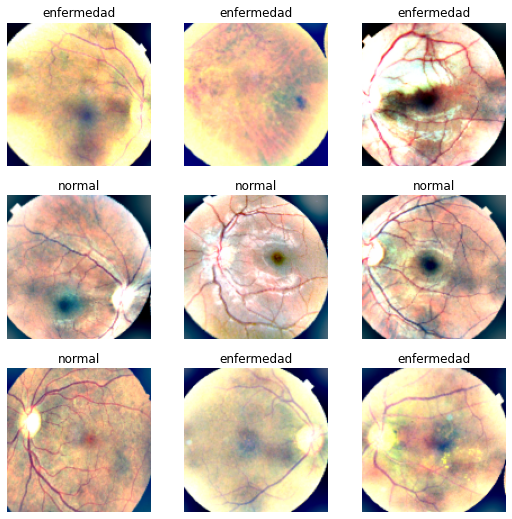

In [ ]:
dls.show_batch()

In [ ]:
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=20),
    SaveModelCallback(fname='modelResnet18')  
]

In [ ]:
learn = cnn_learner(dls,resnet18,metrics=accuracy,cbs=callbacks).to_fp16()


/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

SuggestedLRs(minimum=0.012022644281387329, steep=0.019054606556892395, valley=0.0012022644514217973, slide=0.007585775572806597)

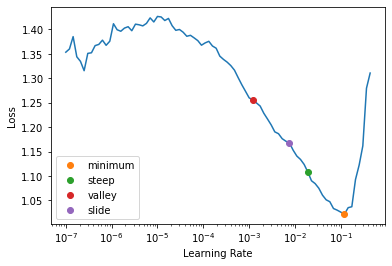

In [ ]:
learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

## Entrenamos el modelo

epoch,train_loss,valid_loss,accuracy,time
0,1.050082,2.509019,0.453125,00:07


Better model found at epoch 0 with valid_loss value: 2.509018898010254.


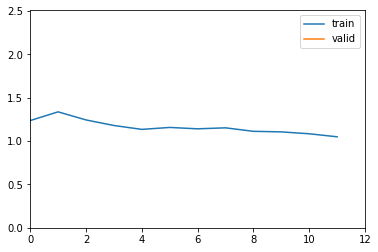

epoch,train_loss,valid_loss,accuracy,time
0,0.714929,0.561386,0.734375,00:06
1,0.572428,0.392076,0.833333,00:06
2,0.496576,0.361289,0.854167,00:06
3,0.442502,0.358301,0.854167,00:06
4,0.402249,0.364293,0.848958,00:06
5,0.371035,0.323033,0.872396,00:06
6,0.341308,0.694753,0.804688,00:07
7,0.316213,0.341502,0.851562,00:07
8,0.286841,0.562442,0.828125,00:06
9,0.267225,0.427829,0.856771,00:06


Better model found at epoch 0 with valid_loss value: 0.5613858699798584.


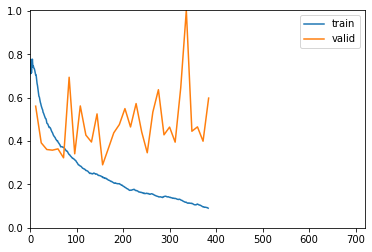

Better model found at epoch 1 with valid_loss value: 0.3920764923095703.
Better model found at epoch 2 with valid_loss value: 0.36128851771354675.
Better model found at epoch 3 with valid_loss value: 0.3583013713359833.
Better model found at epoch 5 with valid_loss value: 0.3230334222316742.
Better model found at epoch 12 with valid_loss value: 0.2906792163848877.
No improvement since epoch 12: early stopping


In [ ]:
learn.fine_tune(60,base_lr=1e-2)

Exportamos el modelo

In [ ]:
learn.to_fp32()
learn.export('modeloBinario.pkl')

## Evaluando el modelo

In [ ]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=aug_transforms(size=128,min_scale=0.75))
dlsTest = dbTest.dataloaders(path,bs=128)

In [ ]:
learn.dls = dlsTest

El valor de la función de perdida es de 0.34 y su accuracy es del 86.5%.

In [ ]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.8656250238418579.


(#2) [0.3400197923183441,0.8656250238418579]

## Interpretación del modelo

In [ ]:
learn.dls=dls

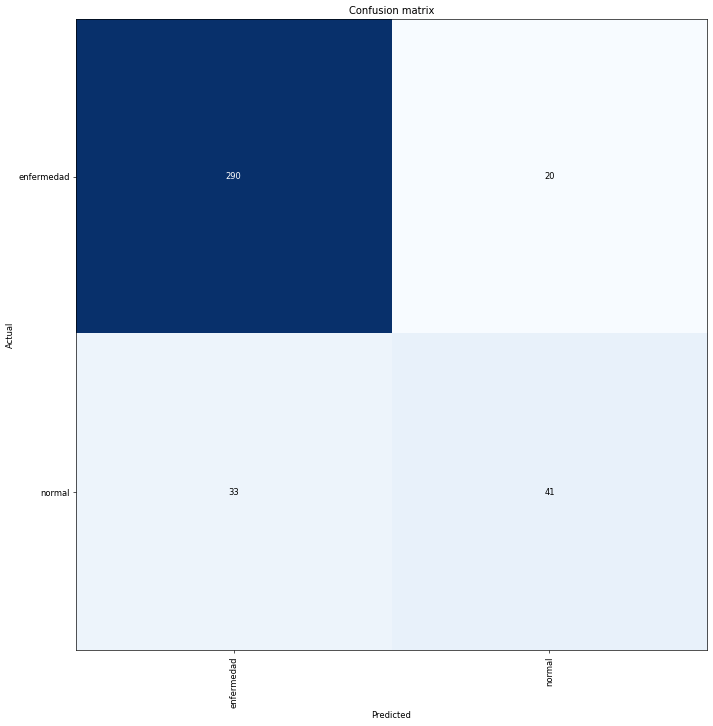

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

# Clasificador Sin Procesar Imágenes

In [1]:
from fastai.vision.all import *

In [3]:
!wget https://www.dropbox.com/s/1isaa8xrrv0x6n4/datasetComprimido.zip?dl=0 --no-verbose -O datasetComp.zip

2022-06-14 17:42:16 URL:https://ucae6fc7287d1c8cea5141ecb57b.dl.dropboxusercontent.com/cd/0/inline2/BnMskXE0fUadaU01YBI0-rr_gyjY1J0Zl2J7IwTbVyNpYLcp46whJxRhdq_WdkImon9BRH5lSCZ2jftKJ0qnH6_S8Wqt-O4q6hqJNyK_KhytPNE3khU48cHkoarpCt4uEy5K5Tk8wsQfwZrHT0ApL1LH3jcFoxVyNo_4cf1QWIxIrlIi0_thvIsa-uYftMOWuLJRVPIz7gkTiG0AdOoplCp7wpxy5G1raItw0Fmi8BZyA3oADE1_bYe6ayavr8Z9tUr0T841EVrdAq2yS1s1LULNXNLyierfVQtFZS8EFyXbhOOZf5RI9MWcqhSANl19_ZMVJkgqGfmtlC7yk2f0JLb-V9qOW_qpdhHkN0913y-pqW-3Rr-dCitCc-hK6ucKzvXdVS-Np9fpSoUbPpB4DnaaxE5n9g4ko_7qTBFZSERIvg/file [144922725/144922725] -> "datasetComp.zip" [1]


In [4]:
!unzip -qq datasetComp.zip

In [6]:
trainPath = Path('Training_Set_C/')
testPath  = Path('Test_Set_C/')
valPath  =  Path('Evaluation_Set_C/')

In [7]:
df_train = pd.read_csv(str(trainPath) + '/train.csv')
df_test = pd.read_csv(str(testPath) + '/test.csv')
df_val = pd.read_csv(str(valPath) + '/val.csv')

In [11]:
import shutil
for id, enf in zip(df_train['ID'], df_train['Disease_Risk']):
    if(int(enf)==0):
        shutil.move(str(trainPath)+'/Training/' + str(id) + '.png', trainN)
    else:
        shutil.move(str(trainPath)+'/Training/' + str(id) + '.png', trainE)

for id, enf in zip(df_test['ID'], df_test['Disease_Risk']):
    if(int(enf)==0):
        shutil.move(str(testPath)+'/Test/' + str(id) + '.png', testN)
    else:
        shutil.move(str(testPath)+'/Test/' + str(id) + '.png', testE)
for id, enf in zip(df_val['ID'], df_val['Disease_Risk']):
    if(int(enf)==0):
        shutil.move(str(valPath)+'/Validation/' + str(id) + '.png', valN)
    else:
        shutil.move(str(valPath)+'/Validation/' + str(id) + '.png', valE)

In [16]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(valid_pct=0.2,seed=42),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=aug_transforms(size=128,min_scale=0.75))

In [17]:
trainPath = Path('dataset/train')

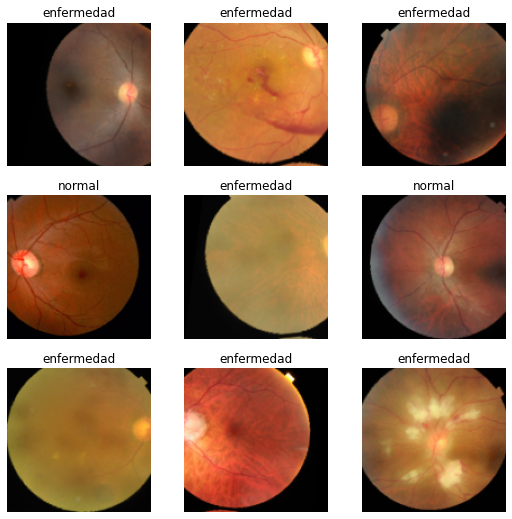

In [20]:
dls = db.dataloaders(trainPath,bs=128)
dls.show_batch()

In [21]:
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=20),
    SaveModelCallback(fname='modelResnet18')  
]

In [22]:
learn = cnn_learner(dls,resnet18,metrics=accuracy,cbs=callbacks).to_fp16()

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


SuggestedLRs(minimum=0.010000000149011612, steep=0.0002754228771664202, valley=0.0005754399462603033, slide=0.0063095735386013985)

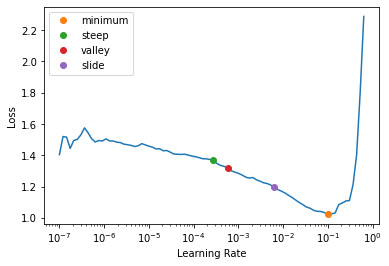

In [23]:
learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

epoch,train_loss,valid_loss,accuracy,time
0,1.370977,1.049436,0.442708,00:09


Better model found at epoch 0 with valid_loss value: 1.0494359731674194.


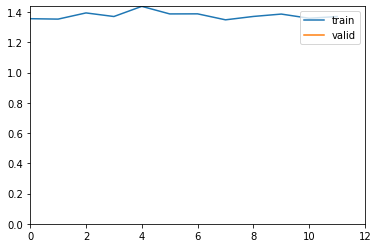

epoch,train_loss,valid_loss,accuracy,time
0,1.259107,0.934507,0.507812,00:09
1,1.216002,0.890913,0.536458,00:08
2,1.200848,0.835302,0.554688,00:06
3,1.168685,0.801865,0.562500,00:06
4,1.139372,0.757385,0.588542,00:06
5,1.108600,0.717237,0.619792,00:06
6,1.089646,0.679297,0.664062,00:06
7,1.065431,0.677282,0.687500,00:06
8,1.057576,0.646228,0.703125,00:06
9,1.038068,0.642446,0.710938,00:06


Better model found at epoch 0 with valid_loss value: 0.9345065951347351.


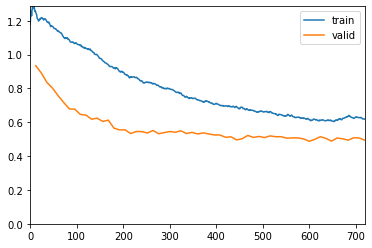

Better model found at epoch 1 with valid_loss value: 0.8909130096435547.
Better model found at epoch 2 with valid_loss value: 0.83530193567276.
Better model found at epoch 3 with valid_loss value: 0.8018649220466614.
Better model found at epoch 4 with valid_loss value: 0.7573845982551575.
Better model found at epoch 5 with valid_loss value: 0.7172372937202454.
Better model found at epoch 6 with valid_loss value: 0.6792972087860107.
Better model found at epoch 7 with valid_loss value: 0.6772815585136414.
Better model found at epoch 8 with valid_loss value: 0.6462276577949524.
Better model found at epoch 9 with valid_loss value: 0.6424462199211121.
Better model found at epoch 10 with valid_loss value: 0.6182074546813965.
Better model found at epoch 12 with valid_loss value: 0.6049867272377014.
Better model found at epoch 14 with valid_loss value: 0.5654913187026978.
Better model found at epoch 15 with valid_loss value: 0.5549833178520203.
Better model found at epoch 17 with valid_loss va

In [24]:
#tiempo de entrenamiento 8 minutos
learn.fine_tune(60,base_lr=1e-4)

## Evaluacion

In [26]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=aug_transforms(size=128,min_scale=0.75))

path = Path('dataset/')
dlsTest = dbTest.dataloaders(path,bs=128)
learn.dls = dlsTest

In [27]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.546875.


(#2) [0.8011258840560913,0.546875]

## Efficientnet_b3a

https://notebooks.githubusercontent.com/view/ipynb?browser=chrome&color_mode=auto&commit=550a08945499aa9ff119547dc4aefbbeec0e5dbf&device=unknown&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f77616c6b776974686661737461692f77616c6b776974686661737461692e6769746875622e696f2f353530613038393435343939616139666631313935343764633461656662626565633065356462662f6e62732f30325f766973696f6e2e65787465726e616c2e74696d6d2e6970796e62&logged_in=false&nwo=walkwithfastai%2Fwalkwithfastai.github.io&path=nbs%2F02_vision.external.timm.ipynb&platform=android&repository_id=295613905&repository_type=Repository&version=98

In [ ]:
trainPath = Path('dataset/train')

In [ ]:
item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.))
batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
bs=16
db = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(0.2),
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms)
dls = db.dataloaders(trainPath, bs=bs)

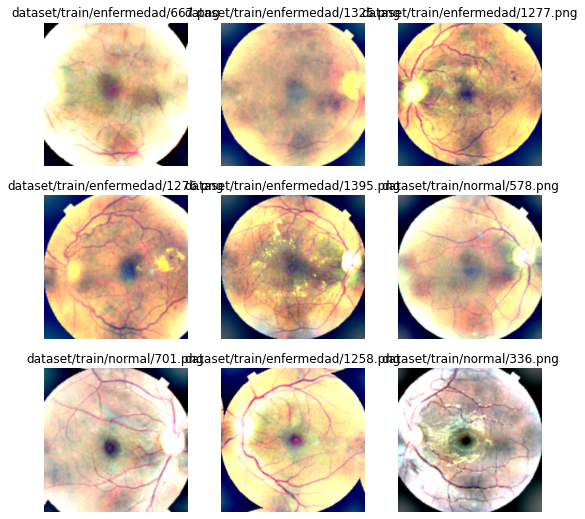

In [ ]:
dls.show_batch()

In [ ]:
!pip install wwf
!pip install nbdev

In [ ]:
from wwf.utils import *
from wwf.vision.timm import *

In [ ]:
learn = timm_learner(dls, 'efficientnet_b3a', metrics=[error_rate, accuracy], cbs=[])

In [ ]:
learn.fine_tune(8)

epoch,train_loss,valid_loss,error_rate,accuracy,time


KeyError: ignored

In [ ]:
learn.show_results(max_n=6, figsize=(7,8))

KeyError: ignored